### example hinton with nmist

https://stats.stackexchange.com/questions/190148/building-an-autoencoder-in-tensorflow-to-surpass-pca
Here is the key figure from the 2006 Science paper by Hinton and Salakhutdinov:

In [58]:
%matplotlib inline  
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import cv2

import keras
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Flatten, Activation,Lambda
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam

In [59]:
def getImaArrays(folder):
    X = []
    y = []
    y_name=[]
    y_filename =[]
    for subfolder in os.listdir(folder):
        index = os.listdir(folder).index(subfolder)
        for image_filename in os.listdir(folder + subfolder):
                img_file = cv2.imread(folder + subfolder + '/' + image_filename , 0)
                if img_file is not None:
                    flbase = os.path.basename(folder + subfolder + '/' + image_filename)
                    X.append(img_file)
                    y.append(index)
                    y_name.append(subfolder)
                    y_filename.append(flbase)
                    
    y = np.array(y, dtype=np.uint8)
    X = np.array(X, dtype=np.uint8)
    X = X.astype('float32')
    y_filename= np.array(y_filename,dtype=object) 
    y_name= np.array(y_name,dtype=object)
    return X,y,y_filename, y_name

In [60]:
X_train, y_train, y_train_file, y_train_name = getImaArrays( '../datasets/images/' + 'train/')
X_train= X_train / 255


In [61]:
# transform 28x28 arrays to 784 array
x_train = X_train.reshape(X_train.shape[0], 784) / 255

In [75]:
np.unique(y_train_name)

array(['apple', 'banana', 'blackberry', 'blueberry', 'grapes', 'peanut',
       'pear', 'strawberry'], dtype=object)

## PCA

In [62]:
mu = x_train.mean(axis=0)
U,s,V = np.linalg.svd(x_train - mu, full_matrices=False)
Zpca = np.dot(x_train - mu, V.transpose())

Rpca = np.dot(Zpca[:,:2], V[:2,:]) + mu    # reconstruction
err = np.sum((x_train-Rpca)**2)/Rpca.shape[0]/Rpca.shape[1]
print('PCA reconstruction error with 2 PCs: ' + str(round(err,3)));

PCA reconstruction error with 2 PCs: 0.0


In [82]:
def plot_scatter(history):
    plt.figure(figsize=(14,8))
    plt.subplot(121)
    plt.title('PCA')
    plt.scatter(Zpca[:5000,0], Zpca[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])
    #plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))

    plt.subplot(122)
    plt.title('Autoencoder')
    plt.scatter(Zenc[:5000,0], Zenc[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])
    #plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))

    plt.tight_layout()
    
def plot_representation(X_train,  Renc):
    plt.figure(figsize=(9,3))
    toPlot = (X_train,  Renc)
    for i in range(10):
        for j in range(2):
            ax = plt.subplot(2, 10, 10*j+i+1)
            plt.imshow(toPlot[j][i,:].reshape(28,28), interpolation="nearest", 
                       vmin=0, vmax=1)
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    
def plot_learning_curve(history):
    fig = plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='center right')
    
    plt.tight_layout()
    

# Autoencoders

************

### model 1

In [64]:
model = Sequential()
model.add(Dense(512,  activation='relu', input_shape=(784,)))
model.add(Dense(2,    activation='linear', name="bottleneck"))
model.add(Dense(512,  activation='relu'))
model.add(Dense(784,  activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
                      #metrics=['accuracy'],
                      optimizer = Adam())

In [65]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               401920    
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 1026      
_________________________________________________________________
dense_26 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_27 (Dense)             (None, 784)               402192    
Total params: 806,674
Trainable params: 806,674
Non-trainable params: 0
_________________________________________________________________
None


In [66]:
#train
history = model.fit(x_train, x_train, batch_size=128, epochs=15, verbose=0, 
                validation_split=0.2)
history_dict = history.history
history_dict.keys()

encoder = Model(model.input, model.get_layer('bottleneck').output)
Zenc = encoder.predict(x_train)  # bottleneck representation
Renc = model.predict(x_train)        # reconstruction

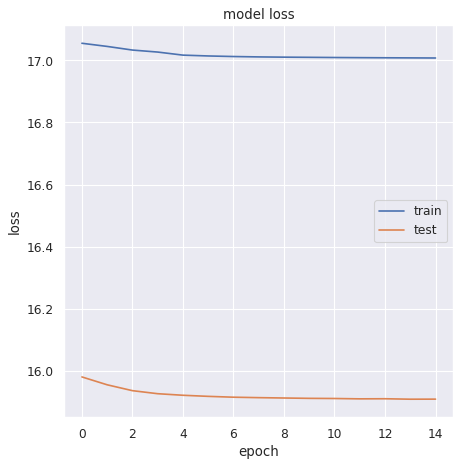

In [67]:
plot_learning_curve(history)

In [81]:
plot_scatter(history)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


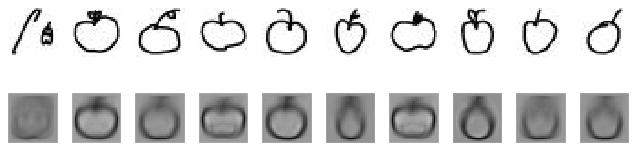

In [69]:
plot_representation(X_train,  Renc)

************

### model 2

In [70]:
model = Sequential()
model.add(Dense(512,  activation='relu', input_shape=(784,)))
model.add(Dense(128,  activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(2,    activation='linear', name="bottleneck"))
#model.add(Dropout(1))
model.add(Dense(128,  activation='relu'))
model.add(Dense(512,  activation='relu'))
model.add(Dense(784,  activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer = Adam())

In [71]:
#train
history = model.fit(x_train, x_train, batch_size=128, epochs=50, verbose=0, 
                validation_split=0.2,)
history_dict = history.history
history_dict.keys()
encoder = Model(model.input, model.get_layer('bottleneck').output)
Zenc = encoder.predict(x_train)  # bottleneck representation
Renc = model.predict(x_train)        # reconstruction

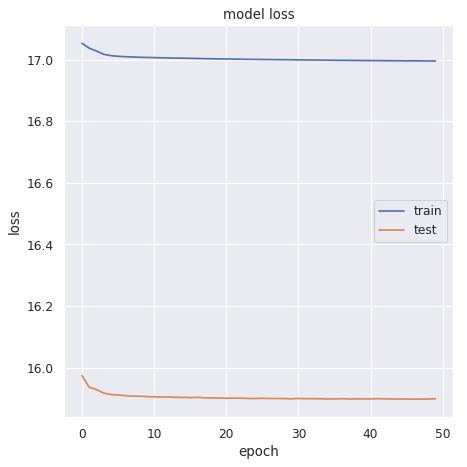

In [72]:
plot_learning_curve(history)

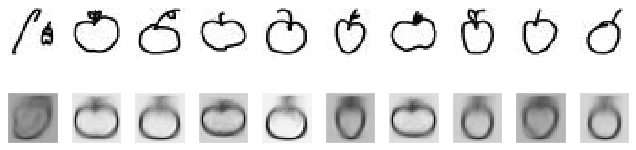

In [73]:
plot_representation(X_train,  Renc)

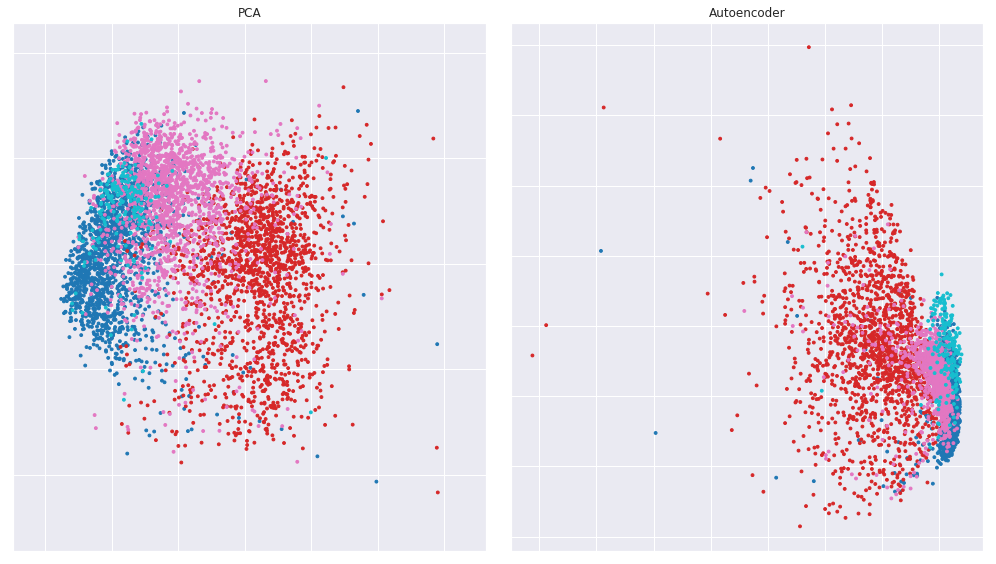

In [74]:
plot_scatter(history)

In [57]:
# agregar mas capas
# otras activaciones
# peso de las capas
# probar con algunas frutas solo


**********************

In [57]:
model = Sequential()
model.add(Dense(512,  activation='relu', input_shape=(784,)))
model.add(Dropout(0.65))
model.add(Dense(128,  activation='relu'))
model.add(Dropout(0.65))
model.add(Dense(2,    activation='linear', name="bottleneck"))
model.add(Dropout(0.65))
model.add(Dense(128,  activation='relu'))
model.add(Dropout(0.65))
model.add(Dense(512,  activation='relu'))
model.add(Dropout(0.65))
model.add(Dense(784,  activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer = Adam())

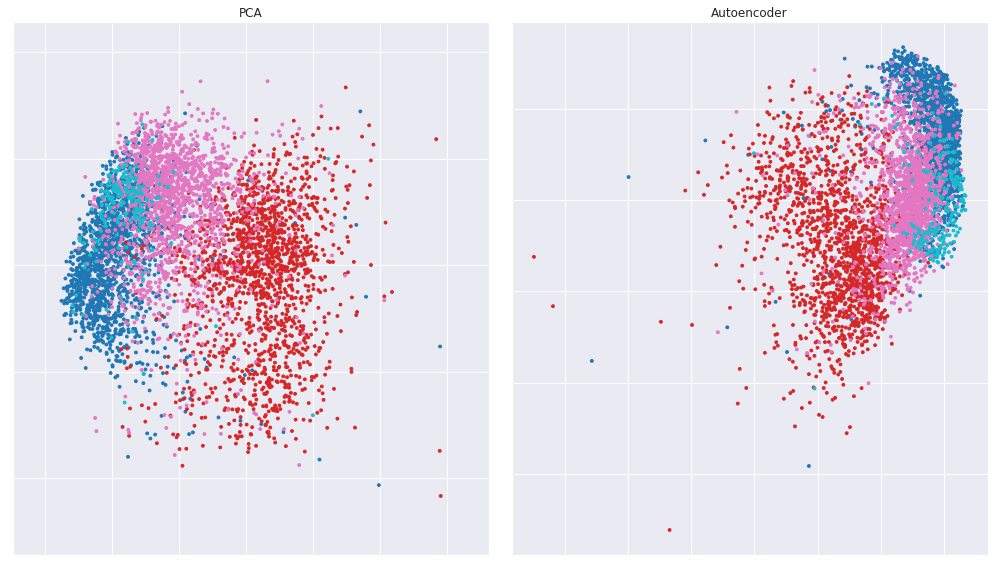

(By the way, it is instructive to change all activation functions to activation='linear' and to observe how the loss converges precisely to the PCA loss. That is because linear autoencoder is equivalent to PCA.)

Reconstructions

And now let's look at the reconstructions (first row - original images, second row - PCA, third row - autoencoder):

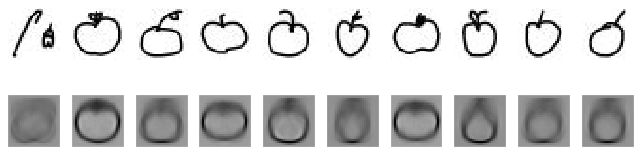

In [26]:
plt.figure(figsize=(9,3))
toPlot = (X_train,  Renc)
for i in range(10):
    for j in range(2):
        ax = plt.subplot(2, 10, 10*j+i+1)
        plt.imshow(toPlot[j][i,:].reshape(28,28), interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.tight_layout()

In [14]:
from keras.layers import Input, Dense
from keras.models import Model


# this is the size of our encoded representations
#encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats·

encoding_dim = 2  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats


# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [ ]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [ ]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

####  lo mismo pero desde R

In [ ]:
#Initialisation

library(keras)
library(rARPACK) # to use SVDS
rm(list=ls())
mnist   = dataset_mnist()
x_train = mnist$train$x
y_train = mnist$train$y
x_test  = mnist$test$x
y_test  = mnist$test$y

# reshape & rescale
dim(x_train) = c(nrow(x_train), 784)
dim(x_test)  = c(nrow(x_test), 784)
x_train = x_train / 255
x_test = x_test / 255

#PCA

mus = colMeans(x_train)
x_train_c =  sweep(x_train, 2, mus)
x_test_c =  sweep(x_test, 2, mus)
digitSVDS = svds(x_train_c, k = 2)

ZpcaTEST = x_test_c %*% digitSVDS$v # PCA projection of test data

#Autoencoder

model = keras_model_sequential() 
model %>%
  layer_dense(units = 512, activation = 'elu', input_shape = c(784)) %>%  
  layer_dense(units = 128, activation = 'elu') %>%
  layer_dense(units = 2,   activation = 'linear', name = "bottleneck") %>%
  layer_dense(units = 128, activation = 'elu') %>% 
  layer_dense(units = 512, activation = 'elu') %>% 
  layer_dense(units = 784, activation='sigmoid')

model %>% compile(
  loss = loss_mean_squared_error, optimizer = optimizer_adam())

history = model %>% fit(verbose = 2, validation_data = list(x_test, x_test),
                         x_train, x_train, epochs = 5, batch_size = 128)

# Unsurprisingly a 3-year old laptop is slower than a desktop
# Train on 60000 samples, validate on 10000 samples
# Epoch 1/5
#  - 14s - loss: 0.0570 - val_loss: 0.0488
# Epoch 2/5
#  - 15s - loss: 0.0470 - val_loss: 0.0449
# Epoch 3/5
#  - 15s - loss: 0.0439 - val_loss: 0.0426
# Epoch 4/5
#  - 15s - loss: 0.0421 - val_loss: 0.0413
# Epoch 5/5
#  - 14s - loss: 0.0408 - val_loss: 0.0403

# Set the auto-encoder
autoencoder = keras_model(model$input, model$get_layer('bottleneck')$output)
ZencTEST = autoencoder$predict(x_test)  # bottleneck representation  of test data


#Plotting PCA projection side-by-side with the bottleneck representation

par(mfrow=c(1,2))
myCols = colorRampPalette(c('green',     'red',  'blue',  'orange', 'steelblue2',
                            'darkgreen', 'cyan', 'black', 'grey',   'magenta') )
plot(ZpcaTEST[1:5000,], col= myCols(10)[(y_test+1)], 
     pch=16, xlab = 'Score 1', ylab = 'Score 2', main = 'PCA' ) 
legend( 'bottomright', col= myCols(10), legend = seq(0,9, by=1), pch = 16 )

plot(ZencTEST[1:5000,], col= myCols(10)[(y_test+1)], 
     pch=16, xlab = 'Score 1', ylab = 'Score 2', main = 'Autoencoder' ) 
legend( 'bottomleft', col= myCols(10), legend = seq(0,9, by=1), pch = 16 )


# reconstructions

Renc = predict(model, x_test)        # autoencoder reconstruction
Rpca = sweep( ZpcaTEST %*% t(digitSVDS$v), 2, -mus) # PCA reconstruction

dev.off()
par(mfcol=c(3,9), mar = c(1, 1, 0, 0))
myGrays = gray(1:256 / 256)
for(u in seq_len(9) ){
  image( matrix( x_test[u,], 28,28, byrow = TRUE)[,28:1], col = myGrays, 
         xaxt='n', yaxt='n')
  image( matrix( Rpca[u,], 28,28, byrow = TRUE)[,28:1], col = myGrays , 
         xaxt='n', yaxt='n')
  image( matrix( Renc[u,], 28,28, byrow = TRUE)[,28:1], col = myGrays, 
         xaxt='n', yaxt='n')
}

# FactorAnalysis with AutoEncoders

In [10]:
#https://stats.stackexchange.com/questions/324107/python-factor-analysis-vs-autoencoderkeras-should-their-values-be-close
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np 


from sklearn.decomposition import FactorAnalysis
from collections import defaultdict


# this is the size of our encoded representations
encoding_dim = 3

x_train=np.array([[2,-1,3],[2.5,-1.5,3.3],[2.2,-1.2,3.6]])

inl= Input(shape=(3,))

encoded = Dense(2, activation='relu')(inl)
decoded = Dense(3)(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inl, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.fit(x_train, x_train,
                epochs=3000,
                batch_size=3, verbose=0)


#print(autoencoder.predict(x_train))


print("\nWeights of Hidden Layer ~=  Should it be the same as  FA-Loadings'ish ?\n")
print(autoencoder.layers[2].get_weights()[0])


fm = FactorAnalysis(n_components=2,max_iter=150).fit(x_train)

print("\nFA-Loadings ~=   Should it be the same as  Autoencoders-weights'ish ?\n")
print(fm.components_)


Weights of Hidden Layer ~=  Should it be the same as  FA-Loadings'ish ?

[[ 0.42027175  0.589043   -0.10341907]
 [-0.7315651  -0.12612426  0.31282437]]

FA-Loadings ~=   Should it be the same as  Autoencoders-weights'ish ?

[[ 2.05480467e-01 -2.05480467e-01  9.73328527e-02]
 [-2.79105661e-13  2.79132063e-13  5.58669980e-02]]


### Another example with batch normalization
https://stackoverflow.com/questions/48817095/keras-how-to-actually-use-an-autoencoder
    

In [12]:
# from keras.layers import Input, Dense, BatchNormalization
# from keras.models import Model
# from keras import regularizers
# from keras.callbacks import TensorBoard, EarlyStopping
# import keras.backend as K
# from sklearn.metrics import r2_score

# input_size = len(spot_dat.columns)
# coder_size = 32
# inner_size = 64
# betwe_size = 96
# outer_size = 128
# batch_size = 25


# def r2(y_true, y_pred):
#     SS_res = K.sum(K.square(y_true - y_pred))
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
#     return (1 - SS_res / (SS_tot + K.epsilon()))

# def rmse(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# input_ = Input(shape=(input_size,))
# encoded = Dense(outer_size, activation='selu')(input_) #hidden 1
# #encoded = Dense(betwe_size, activation='elu')(input_) #hidden 2
# encoded = BatchNormalization()(encoded)
# encoded = Dense(inner_size, activation='selu')(encoded) #hidden 3

# code = Dense(coder_size, activation='selu')(encoded) #code 


# decoded = Dense(inner_size, activation='selu')(code) #hidden 2
# decoded = BatchNormalization()(decoded)
# #decoded = Dense(betwe_size, activation='elu')(decoded) #hidden 2
# decoded = Dense(outer_size, activation='selu')(decoded) #hidden 1
# output = Dense(input_size, activation='sigmoid')(decoded) #output

# autoencoder = Model(input_, output)
# autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = [r2, rmse])
# val = autoencoder.fit(x_train, x_train, 
#                 epochs=1000,
#                 batch_size = 75,
#                 shuffle=True,
#                 validation_data=(x_test, x_test),
#                 callbacks=[TensorBoard(log_dir='/tmp/test'), EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 30, verbose = True, mode = 'auto')])

# plt.plot(val.history['loss'])
# plt.plot(val.history['val_loss'])
# plt.title('Model loss (MSR)')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc = 'best')
# plt.show()

# plt.plot(val.history['r2'])
# plt.plot(val.history['val_r2'])
# plt.title('Model R2')
# plt.ylabel('R2')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc = 'best')
# plt.show()

# plt.plot(val.history['rmse'])
# plt.plot(val.history['val_rmse'])
# plt.title('Model RMSE')
# plt.ylabel('RMSE')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc = 'best')
# plt.show()

In [ ]:
# After training just do the following:
# encoder = Model(input_, code)
# Then use encoder.predict to get the code from an input sample.

In [ ]:
#https://statcompute.wordpress.com/category/python/

from pandas import read_csv, DataFrame
from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
 
df = read_csv("credit_count.txt")
Y = df[df.CARDHLDR == 1].DEFAULTS
X = df[df.CARDHLDR == 1].ix[:, 2:12]
# SCALE EACH FEATURE INTO [0, 1] RANGE
sX = minmax_scale(X, axis = 0)
ncol = sX.shape[1]
X_train, X_test, Y_train, Y_test = train_test_split(sX, Y, train_size = 0.5, random_state = seed(2017))
 
### AN EXAMPLE OF SIMPLE AUTOENCODER ###
# InputLayer (None, 10)
#      Dense (None, 5)
#      Dense (None, 10)
 
input_dim = Input(shape = (ncol, ))
# DEFINE THE DIMENSION OF ENCODER ASSUMED 3
encoding_dim = 3
# DEFINE THE ENCODER LAYER
encoded = Dense(encoding_dim, activation = 'relu')(input_dim)
# DEFINE THE DECODER LAYER
decoded = Dense(ncol, activation = 'sigmoid')(encoded)
# COMBINE ENCODER AND DECODER INTO AN AUTOENCODER MODEL
autoencoder = Model(input = input_dim, output = decoded)
# CONFIGURE AND TRAIN THE AUTOENCODER
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')
autoencoder.fit(X_train, X_train, nb_epoch = 50, batch_size = 100, shuffle = True, validation_data = (X_test, X_test))

# THE ENCODER TO EXTRACT THE REDUCED DIMENSION FROM THE ABOVE AUTOENCODER
encoder = Model(input = input_dim, output = encoded)
encoded_input = Input(shape = (encoding_dim, ))
encoded_out = encoder.predict(X_test)
encoded_out[0:2]
#array([[ 0.        ,  1.26510417,  1.62803197],
#       [ 2.32508397,  0.99735016,  2.06461048]], dtype=float32)